<a href="https://colab.research.google.com/github/Yassmina-Abdo/realtime-head-pose-estimation/blob/main/Notebooks/production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mediapipe

     |████████████████████████████████| 32.8 MB 83.7 MB/s 


In [ ]:
import cv2
import dlib
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow 


ModuleNotFoundError: ignored

# Load Data

In [ ]:

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

mp_drawing = mp.solutions.drawing_utils

drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

cap = cv2.VideoCapture(0)

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/Head Pose Estimation ML Project/Pre Trained Model/shape_predictor_68_face_landmarks.dat')
cap = cv2.VideoCapture(0)

-3.8511015465123597
11.583186584024862
0.06726448181085944


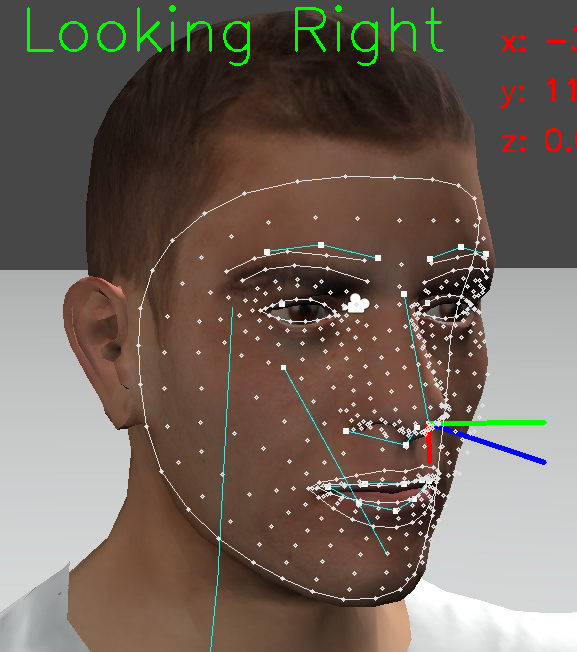

In [ ]:

img = cv2.imread('/content/drive/MyDrive/Head Pose Estimation ML Project/Dataset/Images/image00074.jpg')
img =cv2.imread('/content/nadertest2.jpeg')
image = cv2.cvtColor(cv2.flip(img, 1), cv2.COLOR_BGR2RGB)

# To improve performance
image.flags.writeable = False

# Get the result
results = face_mesh.process(image)

# To improve performance
image.flags.writeable = True

# Convert the color space from RGB to BGR
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

img_h, img_w, img_c = image.shape
face_3d = []
face_2d = []

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        for idx, lm in enumerate(face_landmarks.landmark):
            if idx == 33 or idx == 263 or idx == 1 or idx == 61 or idx == 291 or idx == 199:
                if idx == 1:
                    nose_2d = (lm.x * img_w, lm.y * img_h)
                    nose_3d = (lm.x * img_w, lm.y * img_h, lm.z * 3000)

                x, y = int(lm.x * img_w), int(lm.y * img_h)

                # Get the 2D Coordinates
                face_2d.append([x, y])

                # Get the 3D Coordinates
                face_3d.append([x, y, lm.z])       
        
        # Convert it to the NumPy array
        face_2d = np.array(face_2d, dtype=np.float64)

        # Convert it to the NumPy array
        face_3d = np.array(face_3d, dtype=np.float64)

        # The camera matrix
        focal_length = 1 * img_w

        cam_matrix = np.array([ [focal_length, 0, img_h / 2],
                                [0, focal_length, img_w / 2],
                                [0, 0, 1]])

        # The distortion parameters
        dist_matrix = np.zeros((4, 1), dtype=np.float64)

        # Solve PnP
        success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)

        # Get rotational matrix
        rmat, jac = cv2.Rodrigues(rot_vec)

        # Get angles
        angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)

        # Get the y rotation degree
        x = angles[0] * 360  #roll
        y = angles[1] * 360  #pitch
        z = angles[2] * 360  #yaw

        print(x)
        print(y)
        print(z)

        # See where the user's head tilting
        if y < -10:
            text = "Looking Left"
        elif y > 10:
            text = "Looking Right"
        elif x < -10:
            text = "Looking Down"
        elif x > 10:
            text = "Looking Up"
        else:
            text = "Forward"

        # Display the nose direction
        nose_3d_projection, jacobian = cv2.projectPoints(nose_3d, rot_vec, trans_vec, cam_matrix, dist_matrix)

        p1 = (int(nose_2d[0]), int(nose_2d[1]))
        p2 = (int(nose_2d[0] + y * 10) , int(nose_2d[1] - x * 10))  # pitch , roll = rotation yaw
        p3 = (int(nose_2d[0] + y * 10) , int(nose_2d[1] - z * 10))  # pitch , yaw  = rot roll
        p4 = (int(nose_2d[0] + z * 10) , int(nose_2d[1] - x * 10))  # yaw , roll   = rot pitch
        
        # Draw Lines of yaw roll pitch
        cv2.line(image, p1, p2, (255, 0, 0), 3)  #yaw   blue
        cv2.line(image, p1, p3, (0, 255, 0), 3)  #roll  green
        cv2.line(image, p1, p4, (0, 0, 255), 3)  #pitch red

        # Add the text on the image
        cv2.putText(image, text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
        cv2.putText(image, "x: " + str(np.round(x,2)), (500, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.putText(image, "y: " + str(np.round(y,2)), (500, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.putText(image, "z: " + str(np.round(z,2)), (500, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    mp_drawing.draw_landmarks(image=image,landmark_list=face_landmarks,connections=mp_face_mesh.FACEMESH_CONTOURS,landmark_drawing_spec=drawing_spec,
                connection_drawing_spec=drawing_spec)


cv2_imshow(image)
